In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
df_gscore = pd.read_csv('genome-scores.csv')
df_gtags = pd.read_csv('genome-tags.csv')
df_links = pd.read_csv('links.csv')
df_movies = pd.read_csv('movies.csv')
df_rating = pd.read_csv('ratings.csv')
df_tagspd = pd.read_csv('tags.csv')

## Creating the genome dataset

In [2]:
df_gtagscore=df_gtags.merge(df_gscore, how='right', on='tagId').drop('tag', axis =1)
df_gtagscore.drop_duplicates(subset=['tagId', 'movieId'],inplace=True)
df_gtagscore.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   tagId      11709768 non-null  int64  
 1   movieId    11709768 non-null  int64  
 2   relevance  11709768 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 357.4 MB


# pivoting the datafram

In [3]:
df_gtagscore = df_gtagscore.pivot(index = 'movieId', columns = 'tagId', values='relevance')

In [12]:
df_gtagscore.shape

(10381, 1128)

# Feature reduction with PCA

## adding realease year and genres as columns

In [4]:
df_movies = pd.read_csv('movies.csv')
mask = df_movies['title'].str.contains('09–')

df_movies = pd.read_csv('movies.csv')
def condition(x):
    if x[-2:]=='a)':
        return np.nan
    elif x[-2:]=='l)':
        return np.nan
    elif x[-3:-1]=='7-':
        return 2007
    elif x[-4:-2]=='9–':
        return 2009
    elif x[-2:]=='))':
        return x[-6:-2]
    elif x[-1:]==')':
        return x[-5:-1]
    elif x[-1:]==' ':
        return x[-6:-2]
    else:
        return np.nan
df_movies['releaseyear'] = df_movies['title'].apply(condition).fillna(1993)

In [5]:
df_movies.genres= df_movies.genres.str.split('|')
dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)
df_movies = pd.concat([df_movies, dummies], axis=1).drop('genres', axis=1)

C:\Users\HamidEsfahlani\AppData\Local\Temp\ipykernel_15436\1447042938.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)


In [6]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
df_movies =df_movies.drop('title', axis =1)
"""
le = LabelEncoder()
le.fit(df_movies.genres)
df_movies.genres= le.transform(df_movies.genres)

scaler = MinMaxScaler()
df_movies.genres = scaler.fit_transform(df_movies[['genres']])
"""
scaler02 = MinMaxScaler()
df_movies.releaseyear = scaler02.fit_transform(df_movies[['releaseyear']])

In [7]:
df_ContBaseRec = pd.merge(df_gtagscore, df_movies, how='inner', on='movieId').set_index('movieId')
df_ContBaseRec.columns = df_ContBaseRec.columns.astype(str)

## Clustering

# importing the libraries

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


class elbowMethod():

    # This function works to train a Kmeans model with a list of n_clusters
    # and evaluate the results y calculating the distortion of each n_cluster and show it in a elbow method graph
    # and the differences´of the distortion between two consecutive clusters
    # and a graph showing the silhouette score

    def __init__(self, matrix):
        self.matrix = matrix
        self.wcss = list()
        self.differences = list()
        self.clusters = list()

    def run(self, Start=1, Stop=10, Step=1, max_iterations=300):
        # defining a list of n_clusters with a start, stop and the steps, just like numpy.arange
        self.clusters = np.arange(Start, Stop, Step)
        # initiating and training a Kmeans model with for each value of n_cluster in the list above
        for i in self.clusters:
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=max_iterations, n_init='auto', random_state=0)
            kmeans.fit(self.matrix)
            # appending the distortions of each iteration in a list
            self.wcss.append(kmeans.inertia_ / np.size(self.matrix, axis=0))
        self.differences = list()
        # saving the difference between two consecutive clusters in the list "differences"
        for i in range(len(self.wcss) - 1):
            self.differences.append(self.wcss[i] - self.wcss[i + 1])

    # showing the plots, we can set a top cluster by 'upto_cluster' argument
    def showPlot(self, boundary=5, upto_cluster=None):

        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(25,10))
        plt.subplot(131).set_title('Elbow Method Graph')
        plt.plot(self.clusters, WCSS)
        plt.grid(visible=True)
        plt.xticks(self.clusters)
        plt.subplot(132).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(self.clusters[1:], DIFF)
        plt.plot(self.clusters[1:], np.ones(len_differences) * boundary, 'r')
        plt.plot(self.clusters[1:], np.ones(len_differences) * (-boundary), 'r')
        plt.xticks(self.clusters)
        plt.grid(visible=True)
        plt.show()


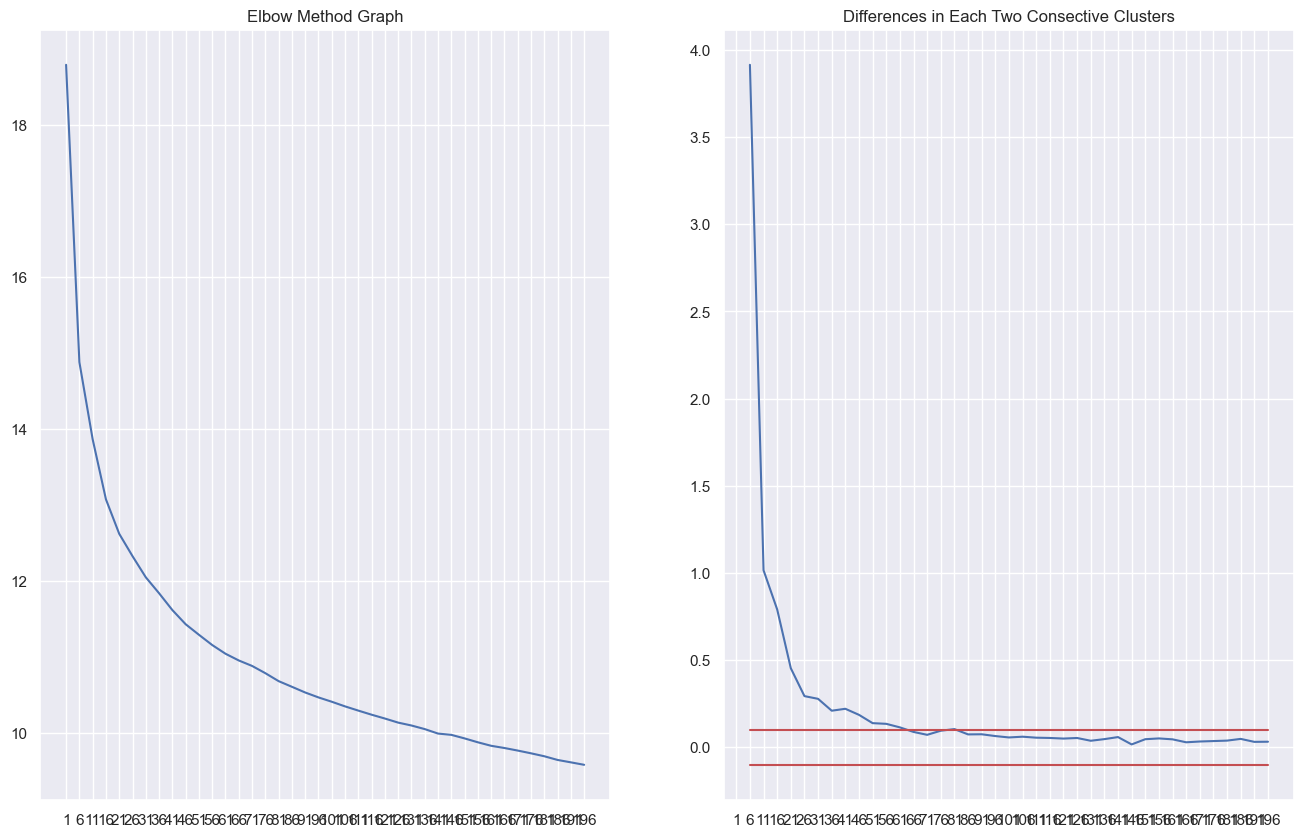

In [14]:
elbow_method = elbowMethod(matrix=df_ContBaseRec)
elbow_method.run(Start=1, Stop=200,Step=5)
elbow_method.showPlot(boundary = 0.1)


The Curve flattens somewhere around 5 and 30 clusters. so we take a closer look

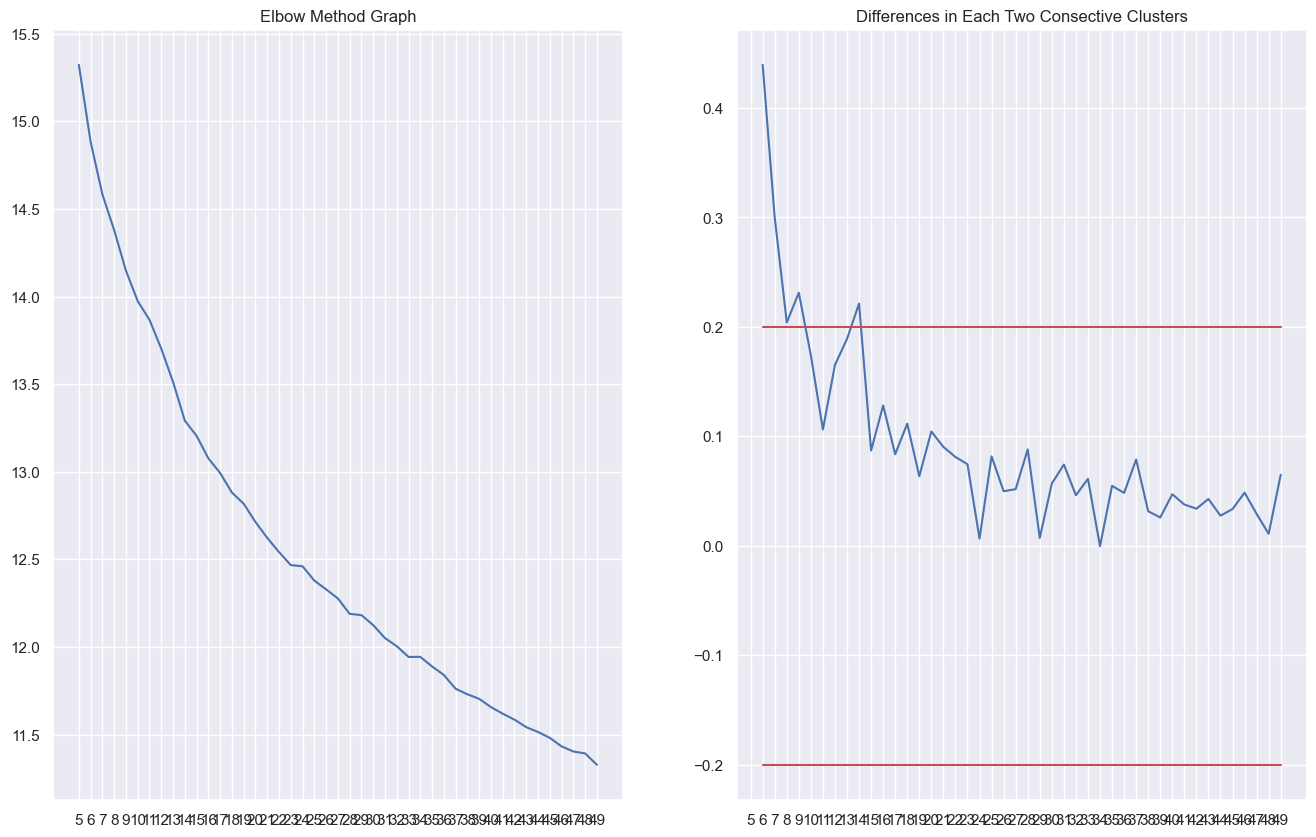

In [16]:
elbow_method = elbowMethod(df_ContBaseRec)
elbow_method.run(Start=5, Stop=50,Step=1)
elbow_method.showPlot(boundary = 0.2)


As we can see 6, 9 and 14 clusters has the best differences and in the Graph there is a flatttening at this number of clusters. After 14 clusters, the difference Curve drops finally in the boundry. We will take a look at the sillouhett score 

# evaluating the silhouette score

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
class SilhouetteAnalyzer:
    def __init__(self, matrix):
        self.matrix = matrix
        self.s_scores = list()
        self.clusters = list()

    def run(self, start=1, stop=10, step=1, max_iterations=300):
        # defining a list of n_clusters with a start, stop and the steps, just like numpy.arrange
        self.clusters = np.arange(start, stop, step)
        # initiating and training a Kmeans model with for each value of n_cluster in the list above
        for i in self.clusters:
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=max_iterations, n_init='auto', random_state=0)
            kmeans.fit(self.matrix)
            self.s_scores.append(silhouette_score(self.matrix, kmeans.labels_, metric='sqeuclidean'))

    def showPlot(self, boundary=500, upto_cluster=None):
        if upto_cluster is None:
            S_SCORE = self.s_scores
        else:
            S_SCORE = self.s_scores[:upto_cluster]
        plt.plot(self.clusters, S_SCORE)
        plt.title('silhouette coef. as a function of the corresponding n_clusters')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette coefficient')
        plt.grid()


In [ ]:
silhouetteScore = SilhouetteAnalyzer(df_ContBaseRec)
silhouetteScore.run(5,25,1) 

In [ ]:
silhouetteScore.showPlot()

In [107]:
from sklearn.metrics import silhouette_score
#silhouette_score(df_ContBaseRec, clf.lables_ , metric='sqeuclidean')

range_n_clusters = np.arange(5,25,1)
s_scores=[]
for k in range_n_clusters:
    KM = KMeans(n_clusters = k, n_init='auto')
    KM.fit(df_ContBaseRec)
    labels = KM.labels_
    s_scores.append(silhouette_score(df_ContBaseRec, labels, metric='sqeuclidean'))


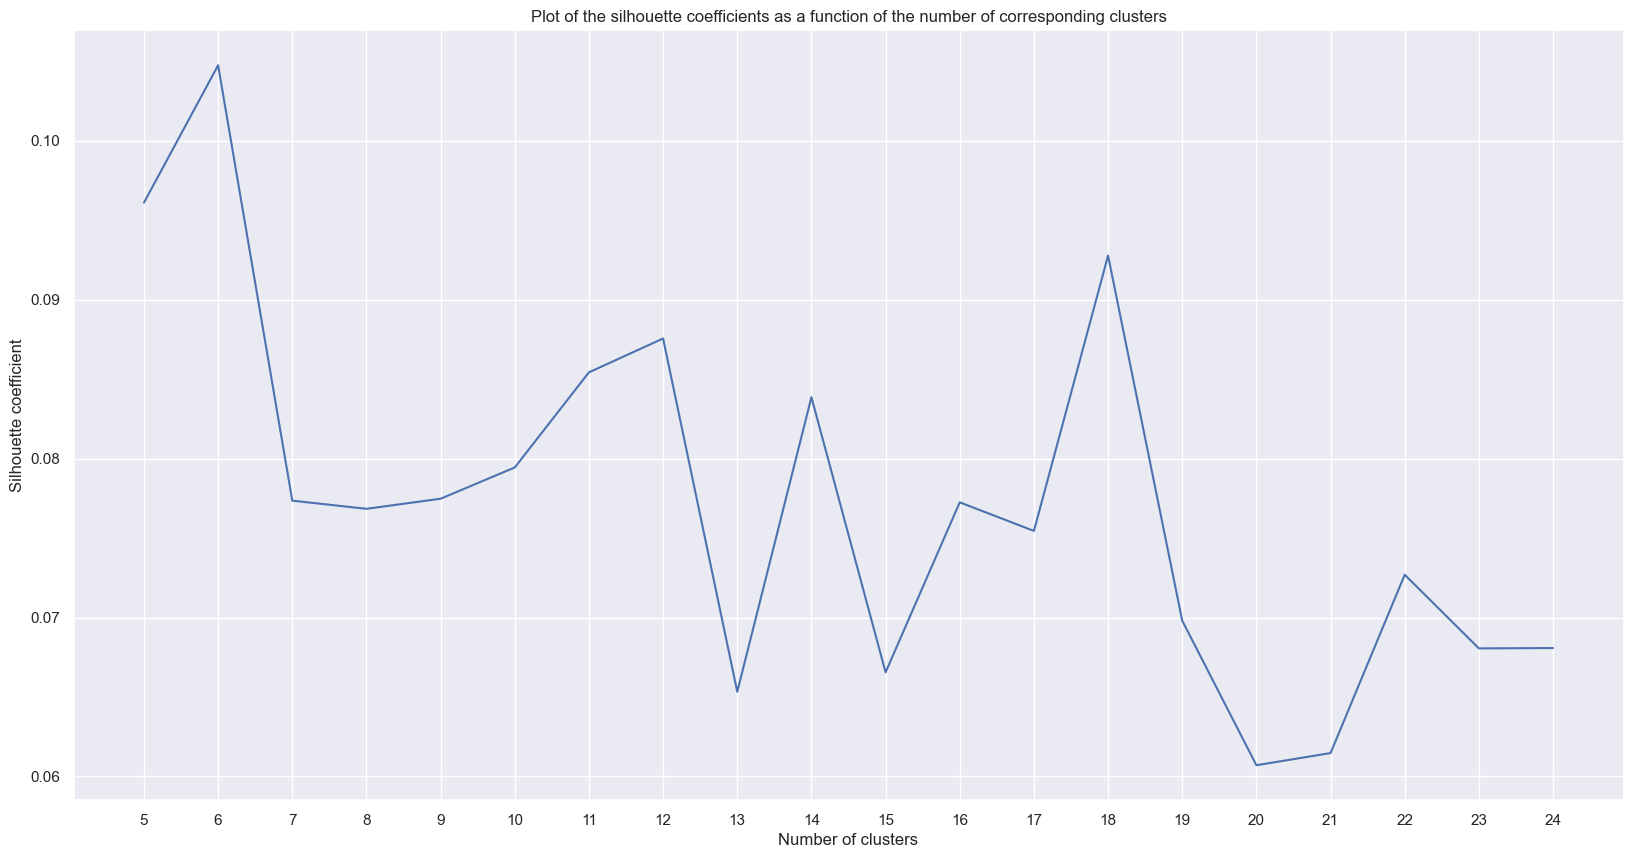

In [112]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(s_scores)
plt.title('Plot of the silhouette coefficients as a function of the number of corresponding clusters')
ax.set_xticks(range(0,20))
ax.set_xticklabels(np.arange(5,25,1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient');

The silhouette score tells the same story. But 18 clusters gains a high silhoutte score. We haven't noted this number in the last graphes and in those graphes 18 doesn't shows low distortion difference, however we will take 14 as a  n_cluster, since we try to consider the highest number of clusters possible.

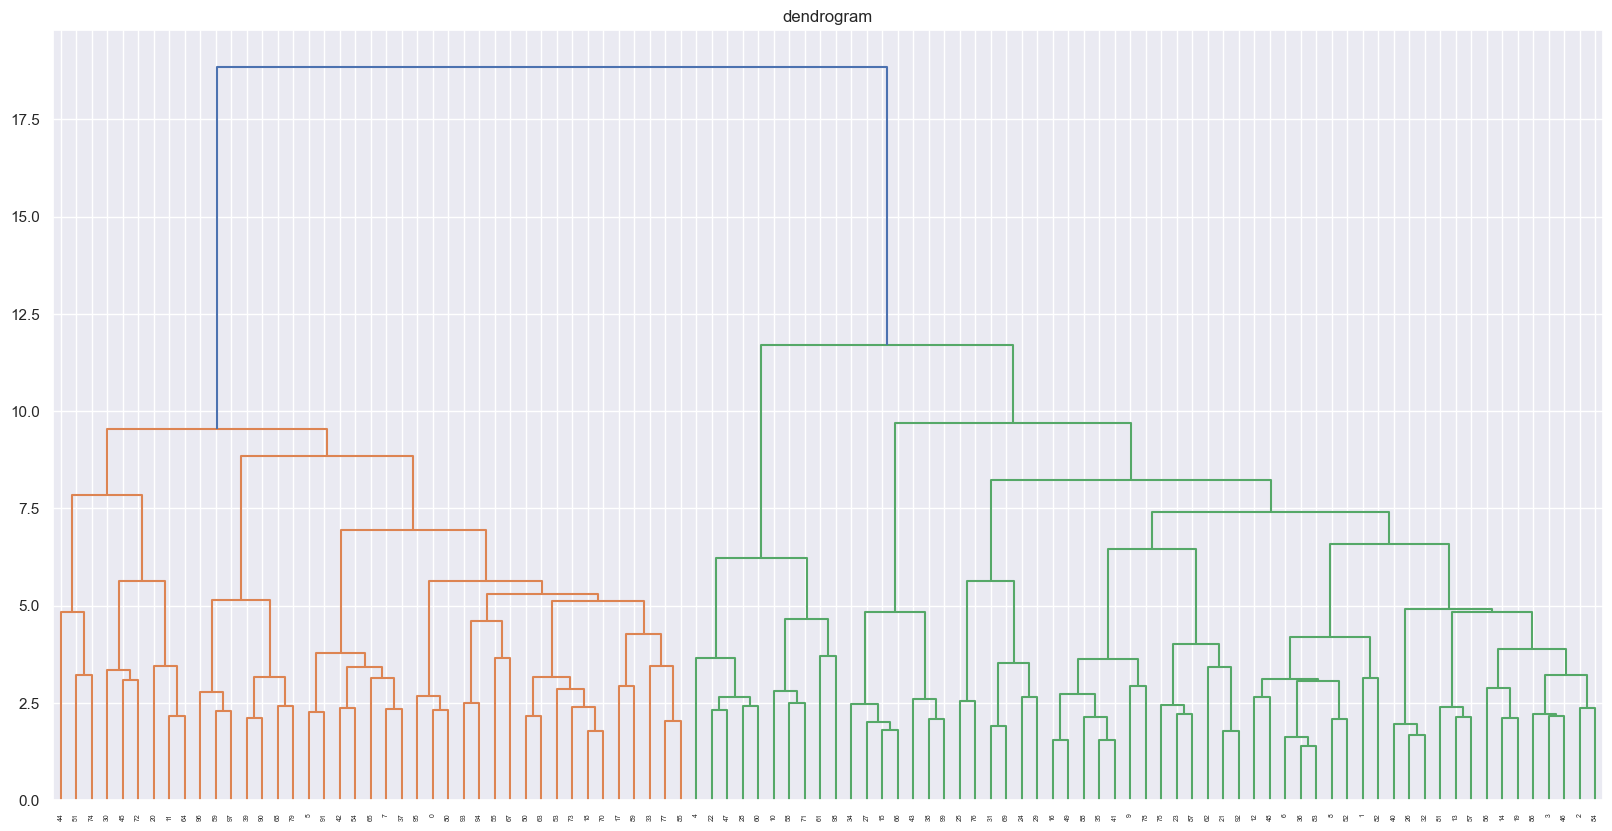

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(centroids, method = 'ward', metric = 'euclidean')
plt.figure(figsize=(20, 10))
plt.title("dendrogram")
dendrogram(Z)
plt.show()


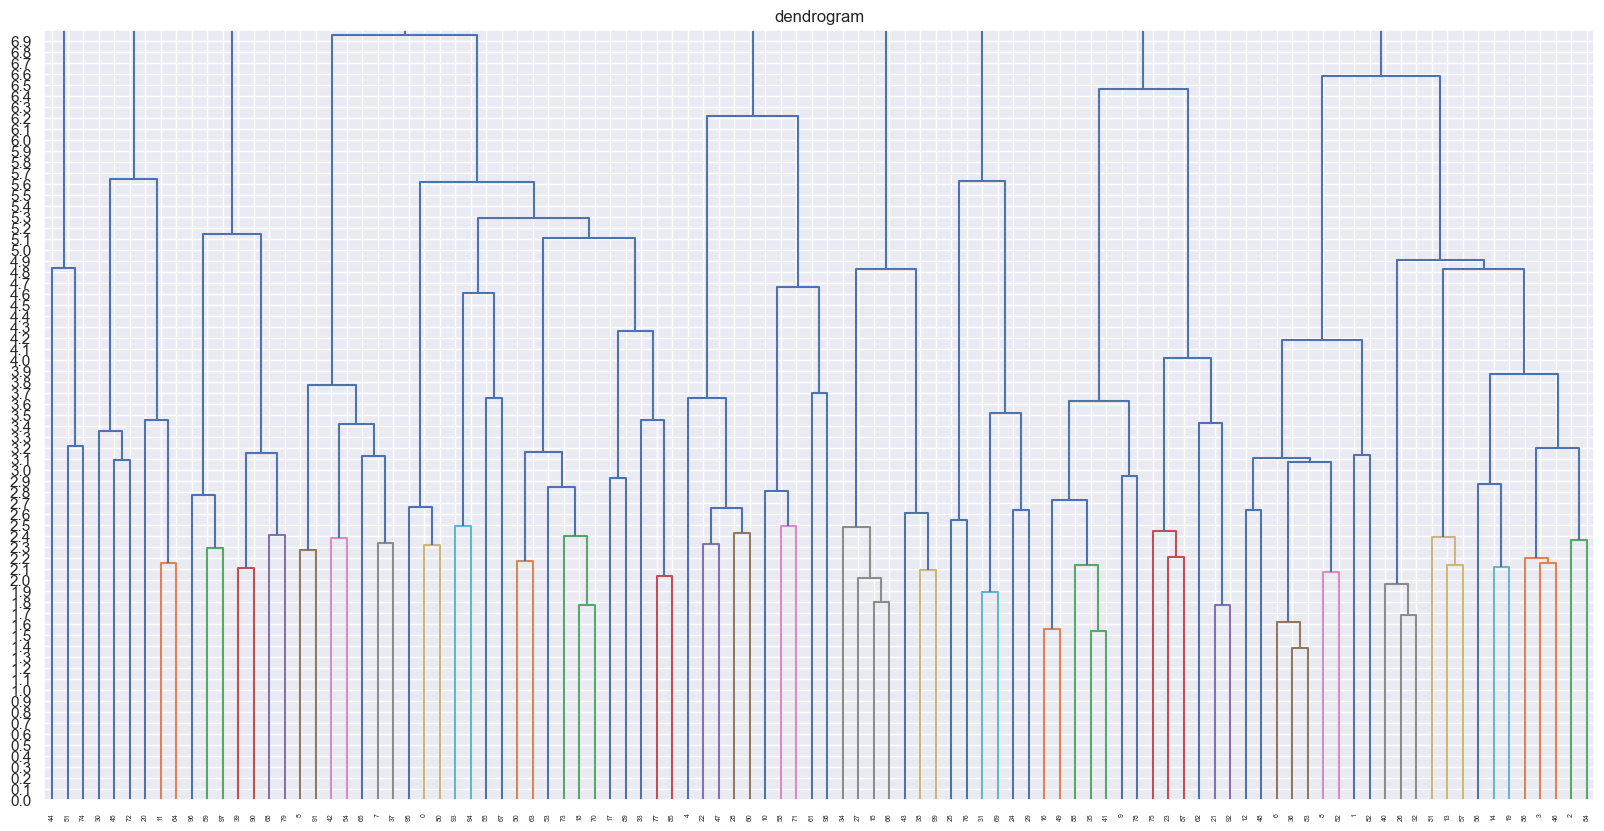

In [33]:
plt.figure(figsize=(20, 10))
plt.title("dendrogram")
dendrogram(Z, color_threshold = 2.5)
plt.yticks(np.arange(0,7,0.1))
plt.ylim(0,7)
plt.show()

In [ ]:
HCA = AgglomerativeClustering(n_clusters = 4)
HCA.fit(centroids)
HCA_labels = HCA.labels_
HCA_centroids = np.zeros((4, df.shape[1]))
for i in range(4):
    HCA_centroids[i] = np.mean(df_scaled[labels == HCA_labels[i]], axis=0)
kmeans_consol = KMeans(n_clusters = 4, init=(Centers.to_numpy()))
kmeans_consol.fit(df_scaled)
labels_consol = kmeans_consol.labels_
